# Deliverable 1
## TODO: idk where to use or where to put this sections of code

## Part 1

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import linalg as la
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    """
    Preprocess a text by tokenizing, lowercasing, removing stop words, and stemming.
    TODO: add bonus points preprocessing (spelling correction, normalizing numbers, 
    synonym replacement / word normalization, etc.)
    """
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]

    # Stem the tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

def clean_seller(text):
    # Remove unwanted trailing phrases and everything after them
    remove_phrases = [
        "Seller changed",
        "(Not Enough Ratin",
        "(New Sell"
    ]
    for phrase in remove_phrases:
        idx = text.find(phrase)
        if idx != -1:
            text = text[:idx]
    return text.strip()

def preprocess_non_textual(document):
    # TODO: preprocess non-textual parts of the document (e.g., numerical data normalization)
    # based on the remaining part of this notebook (section 3 and 4)
    return document

def preprocess_document(document):
    """
    For each textual part of the document, preprocess it
    """

    document.processed_description = preprocess_text(document.description)
    document.processed_title = preprocess_text(document.title)

    document = preprocess_non_textual(document)

    return document


## Section 3
Pros of keeping separate: end user can easily filter products (i.e. if category / sub-category / brand fully matches user filter, product is relevant, otherwise it's not)

Cons of keeping separate: more computation to check general relevance of products

Pros of merging: every aspect of the product helps with relevance (e.g. user can query (not filter) for brands, and the most relevant products will be the one with the user requested brands, but other products, which might still be useful for the user, could still be relevant)

Cons of merging: you lose the option to filter


Maybe some fields could be saved in the inverted index tree using one-hot encoding, to try a hybrid approach, depending on how one wants to build its retrieval engine

## Section 4
out_of_stock: boolean -> if it is out of stock, do not consider this product
selling_price: numerical -> used to filer
discount: numerical -> used to calculate new selling price then filter (could be split into two fields: is_discounted (boolean), discount_value (numerical))
actual_price: numerical -> idk what this is
average_rating: numerical -> filter

## Part 2

In [ ]:
# Exploratory Data Analysis

file_path = "data/fashion_products_dataset.json"  # TODO: fix path to use env variables

# Open and load JSON file
with open(file_path, "r") as f:
    data = json.load(f)
    df = pd.DataFrame(data)

df["seller"] = df["seller"].apply(clean_seller)

print(df.head())


                                    _id actual_price average_rating brand  \
0  fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a        2,999            3.9  York   
1  893e6980-f2a0-531f-b056-34dd63fe912c        1,499            3.9  York   
2  eb4c8eab-8206-59d0-bcd1-a724d96bf74f        2,999            3.9  York   
3  3f3f97bb-5faf-57df-a9ff-1af24e2b1045        2,999            3.9  York   
4  750caa3d-6264-53ca-8ce1-94118a1d8951        2,999            3.9  York   

                   category     crawled_at  \
0  Clothing and Accessories  1612987911000   
1  Clothing and Accessories  1612987912000   
2  Clothing and Accessories  1612987912000   
3  Clothing and Accessories  1612987913000   
4  Clothing and Accessories  1612987913000   

                                         description discount  \
0  Yorker trackpants made from 100% rich combed c...  69% off   
1  Yorker trackpants made from 100% rich combed c...  66% off   
2  Yorker trackpants made from 100% rich combed c...  68% off   


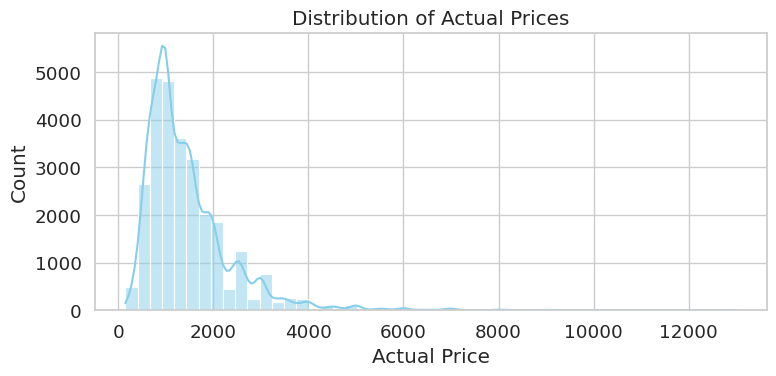

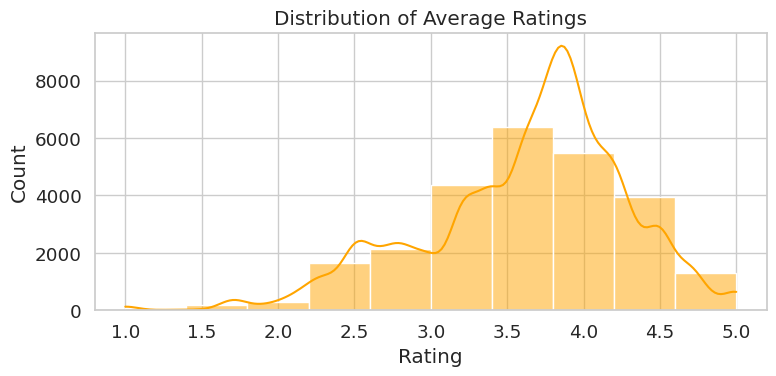

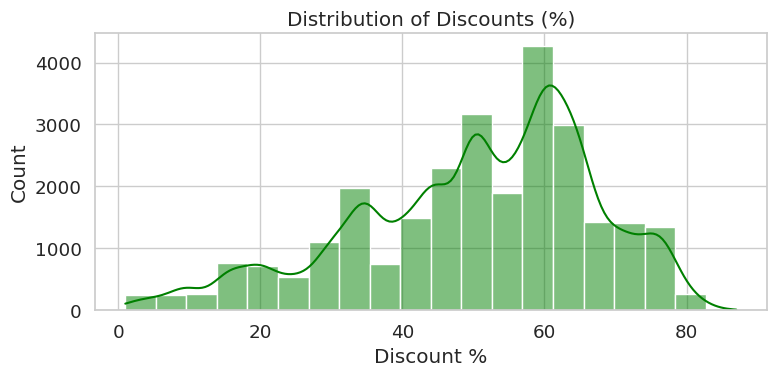

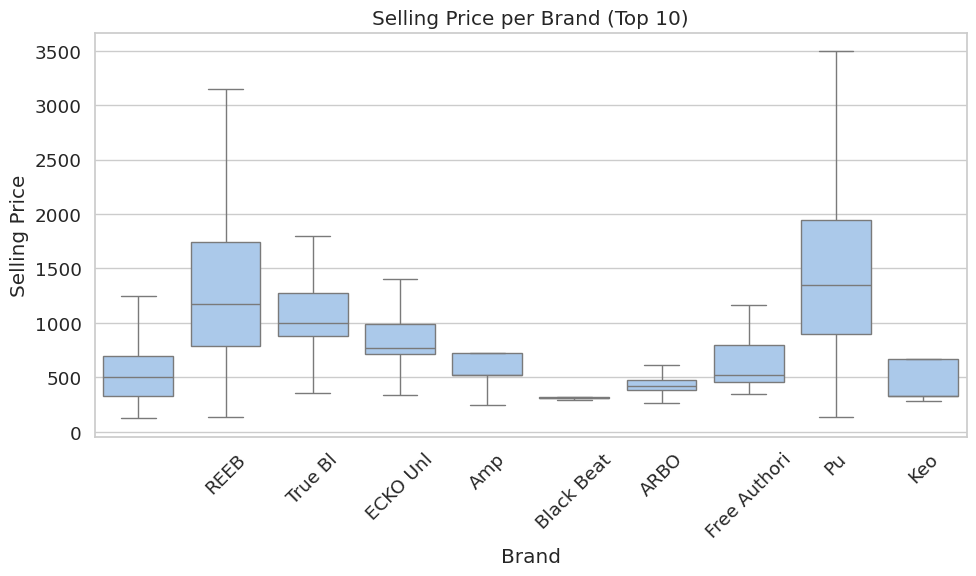

In [63]:
# Convert columns to numeric as before
df["actual_price"] = pd.to_numeric(df["actual_price"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")
df["average_rating"] = pd.to_numeric(df["average_rating"], errors="coerce")
df["discount"] = pd.to_numeric(df["discount"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")
df["selling_price"] = pd.to_numeric(df["selling_price"].astype(str).str.replace(r"[^\d.]", "", regex=True), errors="coerce")

# Set a nicer style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Actual Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["actual_price"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Ratings Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["average_rating"], bins=10, kde=True, color="orange")
plt.title("Distribution of Average Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Discounts Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["discount"], bins=20, kde=True, color="green")
plt.title("Distribution of Discounts (%)")
plt.xlabel("Discount %")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Selling price per brand (top 10 brands)
top_brands = df["brand"].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(x="brand", y="selling_price", data=df[df["brand"].isin(top_brands)], showfliers=False)
plt.title("Selling Price per Brand (Top 10)")
plt.xlabel("Brand")
plt.ylabel("Selling Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [75]:
# Basic Data Exploratory Analysis

# 1. Overview of missing values (NaN and empty strings)
missing_info = df.isnull().sum()
empty_info = (df == '').sum()
print("Missing (NaN) values per column:\n", missing_info)
print("\nEmpty string values per column:\n", empty_info)

# 2. Number of unique brands, categories, sub-categories (excluding empty strings)
print("\nUnique brands (excluding empty):", df.loc[df['brand'] != '', 'brand'].nunique())
print("Unique categories (excluding empty):", df.loc[df['category'] != '', 'category'].nunique())
print("Unique sub-categories (excluding empty):", df.loc[df['sub_category'] != '', 'sub_category'].nunique())

# 3. Top 10 brands by product count (excluding empty)
print("\nTop 10 brands by product count:\n", df.loc[df['brand'] != '', 'brand'].value_counts().head(10))

# 4. Distribution of products by category (excluding empty)
print("\nProduct count by category:\n", df.loc[df['category'] != '', 'category'].value_counts())

# 5. Distribution of products by sub-category (top 10, excluding empty)
print("\nTop 10 sub-categories by product count:\n", df.loc[df['sub_category'] != '', 'sub_category'].value_counts().head(10))

# 6. Out of stock ratio
out_of_stock_ratio = df['out_of_stock'].mean()
print(f"\nOut of stock ratio: {out_of_stock_ratio:.2%}")

# 7. Summary statistics for prices and ratings
print("\nSummary statistics for actual_price, selling_price, discount, average_rating:")
print(df[['actual_price', 'selling_price', 'discount', 'average_rating']].describe())

Missing (NaN) values per column:
 _id                   0
actual_price          0
average_rating     2259
brand                 0
category              0
crawled_at            0
description           0
discount              0
images                0
out_of_stock          0
pid                   0
product_details       0
seller                0
selling_price         0
sub_category          0
title                 0
url                   0
dtype: int64

Empty string values per column:
 _id                    0
actual_price           0
average_rating         0
brand               2009
category               0
crawled_at             0
description        11149
discount               0
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1641
selling_price          0
sub_category           0
title                  0
url                    0
dtype: int64

Unique brands (excluding empty): 324
Unique categories (excluding empty)

In [65]:
# Find products with missing selling_price, actual_price, or discount
missing_prices = df[df['selling_price'].isnull() | df['actual_price'].isnull() | df['discount'].isnull()]

# Print the number of such products
print(f"Number of products with missing selling_price, actual_price, or discount: {len(missing_prices)}")

# Show a few examples
print(missing_prices[['title', 'brand', 'selling_price', 'actual_price', 'discount']].head(10))

Number of products with missing selling_price, actual_price, or discount: 855
                                                  title brand  selling_price  \
1705                 Solid Women Polo Neck Blue T-Shirt  REEB         1099.0   
1734                           Men Striped Ankle Length  REEB          499.0   
1891                       Solid Women Grey Track Pants  REEB         1499.0   
1922                   Full Sleeve Solid Men Sweatshirt  REEB         2399.0   
1949                         Solid Men Grey Track Pants  REEB         1499.0   
1950                  Solid Men Polo Neck Green T-Shirt  REEB         1299.0   
1953                Full Sleeve Solid Men Sports Jacket  REEB         3699.0   
1958                  Solid Men Polo Neck Green T-Shirt  REEB         1599.0   
1964  Original Cotton Half Cushion Women Ankle Lengt...  REEB          399.0   
2020         Printed Women Round Neck Dark Blue T-Shirt  REEB         3999.0   

      actual_price  discount  
1705      

In [66]:
def impute_actual_price(row):
    # if there is no actual price, try to compute it:
    # either from selling price and discount, or just use selling price
    if pd.isnull(row['actual_price']):
        if not pd.isnull(row['selling_price']) and not pd.isnull(row['discount']):
            return row['selling_price'] * (1 - row['discount'] / 100)
        elif not pd.isnull(row['selling_price']):
            return row['selling_price']
    return row['actual_price']

df['actual_price'] = df.apply(impute_actual_price, axis=1)
df['discount'] = df['discount'].fillna(0)
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 _id                   0
actual_price          2
average_rating     2261
brand                 0
category              0
crawled_at            0
description           0
discount              0
images                0
out_of_stock          0
pid                   0
product_details       0
seller                0
selling_price         2
sub_category          0
title                 0
url                   0
dtype: int64


In [67]:
# Drop products with missing actual_price or selling_price
df = df.dropna(subset=['actual_price', 'selling_price'])
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 _id                   0
actual_price          0
average_rating     2259
brand                 0
category              0
crawled_at            0
description           0
discount              0
images                0
out_of_stock          0
pid                   0
product_details       0
seller                0
selling_price         0
sub_category          0
title                 0
url                   0
dtype: int64


In [76]:
df.loc[df['brand'] == '', 'brand'] = 'no brand'

We have done some data cleaning, there are still some products that do not have average rating. For the moment we are just keeping those values, we will decide later what to do with this values. Besides, we could drop crawled_at and images, but for now we keep them.

In [85]:
# Print 5 random entries from the dataset
print(df.sample(5))

                                        _id  actual_price  average_rating  \
2530   132ec430-c7d9-5620-ab13-fbbee83f3193         999.0             NaN   
3667   fce82589-a293-5d09-bc71-e38044c86bc9        1649.0             3.9   
26074  a676d720-2bce-5e72-ac77-96d96407687e        3999.0             3.1   
19698  23ff5b77-6c40-5e13-99ca-04bc66e6b6d3         999.0             4.1   
19934  a9a9576c-25b7-577f-a998-8f690799f551        1599.0             1.8   

              brand                  category     crawled_at  \
2530       no brand  Clothing and Accessories  1612989542000   
3667         Vector                  Footwear  1612990297000   
26074            Pu  Clothing and Accessories  1613005922000   
19698  chawla fashi  Clothing and Accessories  1613001627000   
19934      no brand  Clothing and Accessories  1613001754000   

                                             description  discount  \
2530   TRIPIN BROWN AND SILVER CUFFLINK FOR MEN WITH ...      50.0   
3667   Vecto

Total words: 862062
Vocabulary size: 6315
Average sentence length: 30.702400455872926

Top 5 products by rating:
                                                 title  average_rating
22361                           Men Brief  (Pack of 5)             5.0
8403                       VIP Women Vest  (Pack of 8)             5.0
14764     Graphic Print Women Round Neck White T-Shirt             5.0
13240                           Men Brief  (Pack of 5)             5.0
10472  Men Slim Fit Printed Spread Collar Casual Shirt             5.0

Top 5 cheapest products:
                                             title  selling_price
16485             Women Mid-Calf/Crew  (Pack of 2)           99.0
20435                          Men Printed Bandana           99.0
7654   Women Color Block Ankle Length  (Pack of 3)          118.0
24438          Men Solid Ankle Length  (Pack of 3)          120.0
24437        Women Solid Ankle Length  (Pack of 3)          120.0

Top 5 products by discount:
          

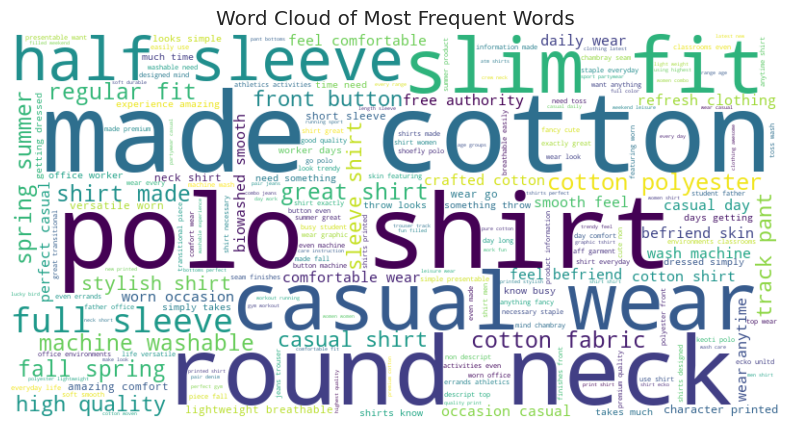

In [87]:
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import re

import matplotlib.pyplot as plt

# 1. Word counting, average sentence length, vocabulary size
all_text = " ".join(df["description"].astype(str).tolist())
# Use a simple regex-based tokenizer instead of nltk.word_tokenize
words = re.findall(r'\b\w+\b', all_text.lower())
vocab = set(words)
print("Total words:", len(words))
print("Vocabulary size:", len(vocab))
print("Average sentence length:", np.mean([len(re.findall(r'\b\w+\b', s.lower())) for s in df["description"].astype(str).tolist()]))

# 2. Ranking of products based on rating, price, discount
print("\nTop 5 products by rating:")
print(df.sort_values("average_rating", ascending=False)[["title", "average_rating"]].head())

print("\nTop 5 cheapest products:")
print(df.sort_values("selling_price")[["title", "selling_price"]].head())

print("\nTop 5 products by discount:")
print(df.sort_values("discount", ascending=False)[["title", "discount"]].head())

# 3. Top sellers and brands
print("\nTop 5 sellers:")
print(df["seller"].value_counts().head())

print("\nTop 5 brands:")
print(df["brand"].value_counts().head())

# 4. Word cloud for most frequent words
filtered_words = [w.lower() for w in words if w.isalpha() and w.lower() not in stopwords.words('english')]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.show()
